In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

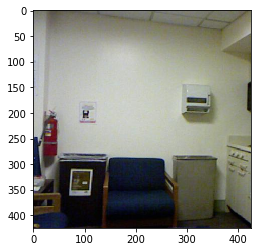

In [3]:
img = plt.imread('data/daquar/images/image1.png')
img = img[:425, :425]
plt.imshow(img)

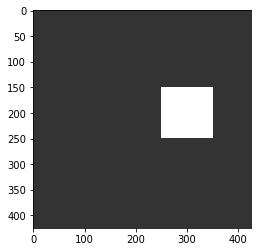

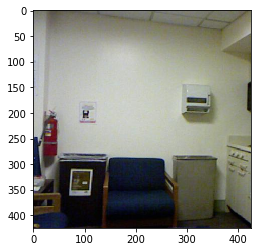

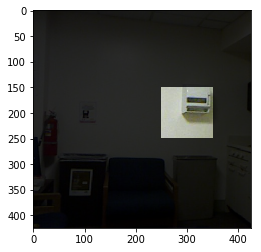

In [4]:
mask = np.zeros(img.shape) + 0.2
mask[150:250, 250:350] = 1
img_copy = img * mask
plt.imshow(mask)
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(img_copy)
plt.show()

### Mask small and Resize it to bigger? (a random mask)

In [5]:
from scipy.misc import imresize

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


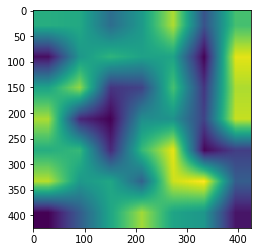

In [6]:
mask = np.random.random([7,7]) 
mask[5, 5] = 1
mask /= np.round(mask.sum() * 256)
mask = imresize(mask, (425, 425), )
mask = mask / 256.0
plt.imshow(mask)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


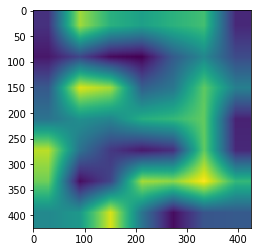

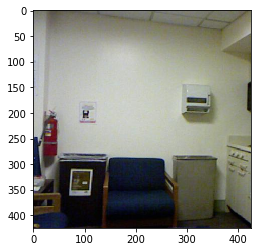

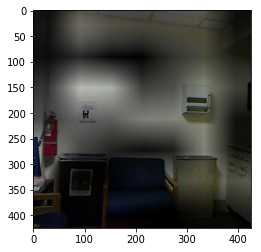

In [7]:
mask = np.random.random([7,7]) 
mask[5, 5] = 1
mask /= np.round(mask.sum() * 256)
mask = imresize(mask, (425, 425), )
mask = mask / 256.0
img_copy = img * np.reshape(mask, [425,425, 1])
plt.imshow(mask)
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(img_copy)
plt.show()

### Using Keras

In [9]:
# limit the GPU card to one
import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

In [27]:
from keras.layers import Dense, Input, Lambda, Flatten, Reshape, TimeDistributed
from keras.models import Model

import keras.backend as K

In [40]:
v = Input([7,7,2048])
q = Input([300])

# examples of composition function?
def cross_modal_comp0(v, q):
    # trnasform v before
    v_transform = Dense(300)(v)

    # flatten v then concatenate
    comp = Lambda(lambda x: K.concatenate([
        K.reshape(x[0], [-1, 7*7*300]),
        x[1]
    ]))([v_transform, q])
    
    return comp

comp0 = cross_modal_comp0(v, q)

def cross_modal_comp1(v, q):
    # repeat q then concatenate with all possible locations.
    comp = Lambda(lambda x: K.concatenate([
        x[0],
        K.reshape(K.repeat_elements(K.expand_dims(x[1], 1), 49, 1), [-1,7,7,300])
    ]))([v, q])
    return comp

def cross_modal_comp2(v, q):
    # repeat q then concatenate with all possible locations.
    comp = Lambda(lambda x: K.concatenate([
        x[0], 
        K.reshape(K.repeat_elements(K.expand_dims(x[1], 2), 49, 2), [-1,7,7,300])
    ]))([v, q])
    # trnasform comp
    comp = Dense(2048, activation='relu')(Flatten()(comp))
    return comp

comp1 = cross_modal_comp1(v, q)

# how to compose vision and language?

# how to create mask (alpha)?
# solution with sigmoid:
#comp = Reshape([49, 2048+300])(comp1)
#alpha = TimeDistributed(Dense(1, activation='sigmoid'))(comp)
#alpha = Reshape([7,7,1])(alpha)

# solution with softmax (recommended):
#comp = Reshape([49 * (2048+300)])(comp1)
# OR:
comp = Flatten()(comp1)
alpha = Dense(49, activation='softmax')(comp)
alpha = Reshape([7,7,1])(alpha)

# masking:
v_masked = v * alpha

comp2 = cross_modal_comp2(v_masked, q)


In [41]:
comp0, comp1, comp2

(<tf.Tensor 'lambda_21/concat:0' shape=(?, 15000) dtype=float32>,
 <tf.Tensor 'lambda_22/concat_1:0' shape=(?, 7, 7, 2348) dtype=float32>,
 <tf.Tensor 'dense_17/Relu:0' shape=(?, 2048) dtype=float32>)

In [ ]:
(?, 7, 7, 2348) -> (?, 7 * 7 * 2348)